In [1]:
from pyspark.sql import SparkSession, Row, functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Tokenizer, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("Sentiment Analysis") \
    .config("spark.jars.packages", 
            "org.apache.spark:spark-mllib_2.12:3.3.0,org.postgresql:postgresql:42.2.25") \
    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")


jdbc_url = "jdbc:postgresql://192.168.1.10:5432/postgres"

jdbc_properties = {
    "user": "postgres",
    "password": "test2021",
    "driver": "org.postgresql.Driver"
}

# Sentiment Distribution: Bar chart showing the number of positive, negative, and neutral tweets/toots.

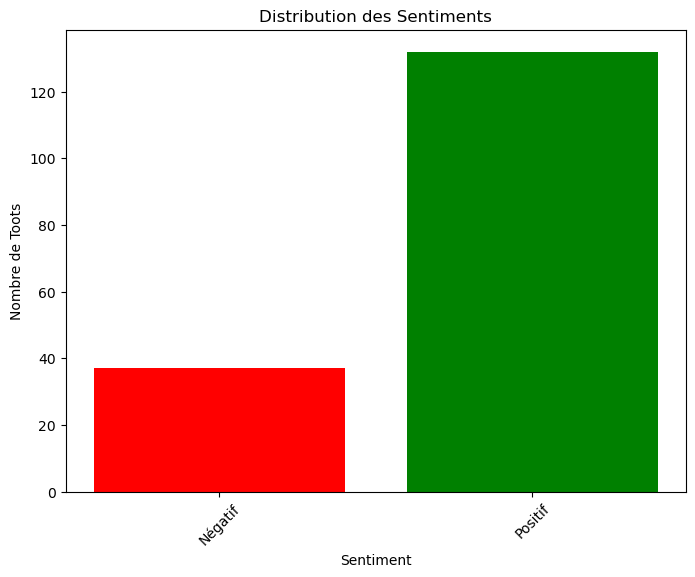

In [3]:
results_df = spark.read.jdbc(url=jdbc_url, table="sentiment_results", properties=jdbc_properties)

sentiment_counts = results_df.groupBy("prediction").count().toPandas()
sentiment_labels = {0: "Négatif", 1: "Positif", 2: "Neutre"}
sentiment_counts["prediction"] = sentiment_counts["prediction"].replace(sentiment_labels)

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts["prediction"], sentiment_counts["count"], color=['red', 'green', 'yellow'])
plt.xlabel("Sentiment")
plt.ylabel("Nombre de Toots")
plt.title("Distribution des Sentiments")
plt.xticks(rotation=45)
plt.show()

# Toot Frequency: Line chart showing the number of toots over time (e.g., per hour/day).

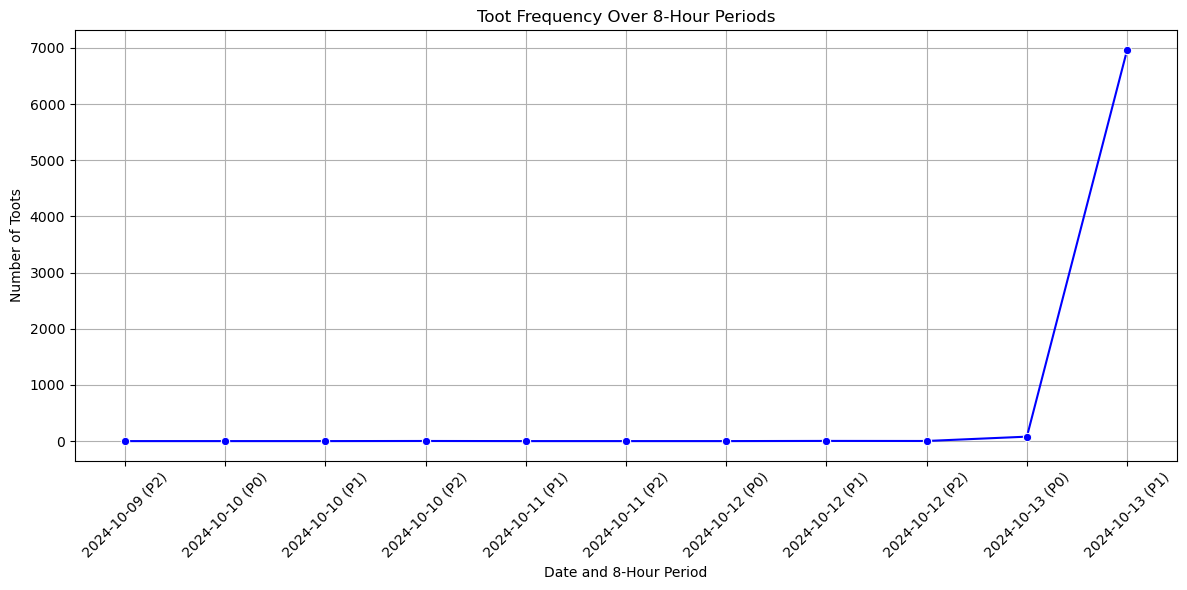

In [4]:
df_toots = spark.read.jdbc(url=jdbc_url, table="toots", properties=jdbc_properties)
df_toots = df_toots.withColumn("period", (F.hour("timestamp") / 8).cast("int"))

df_frequency = df_toots \
    .withColumn("date", F.to_date("timestamp")) \
    .groupBy("date", "period") \
    .count() \
    .orderBy("date", "period")

df_frequency_pd = df_frequency.toPandas()
df_frequency_pd["date_period"] = df_frequency_pd["date"].astype(str) + " (P" + df_frequency_pd["period"].astype(str) + ")"

plt.figure(figsize=(12, 6))
sns.lineplot(x="date_period", y="count", data=df_frequency_pd, marker="o", color="b")
plt.title("Toot Frequency Over 8-Hour Periods")
plt.xlabel("Date and 8-Hour Period")
plt.ylabel("Number of Toots")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Top Hashtags: Horizontal bar chart showing the most frequent hashtags in the dataset.

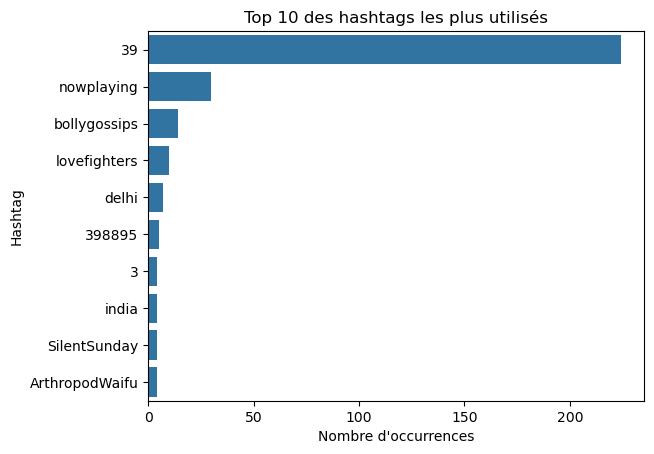

In [5]:
df_hashtags = spark.read.jdbc(url=jdbc_url, table="hashtags", properties=jdbc_properties)

hashtag_counts = df_hashtags.groupBy("hashtag").count().orderBy(F.col("count").desc()).limit(10).toPandas()

sns.barplot(x='count', y='hashtag', data=hashtag_counts)
plt.title("Top 10 des hashtags les plus utilisés")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Hashtag")
plt.show()


# User Activity: Heatmap showing user activity (toots per time window).


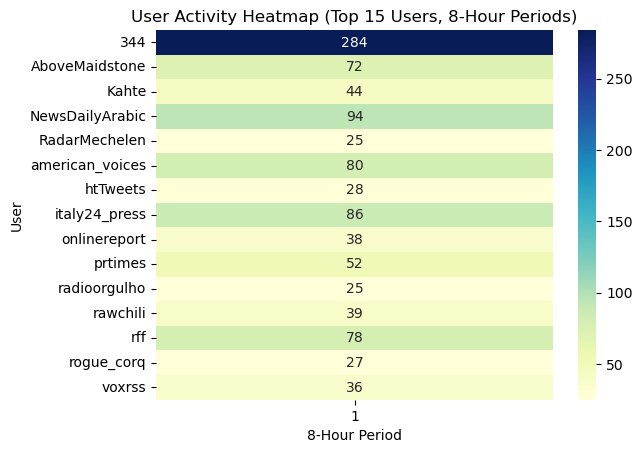

In [8]:
df_activity = spark.read.jdbc(url=jdbc_url, table="toots", properties=jdbc_properties)
df_activity = df_activity.withColumn("period", (F.hour("timestamp") / 8).cast("int"))

user_activity = df_activity \
    .groupBy("user", "period") \
    .count() \
    .orderBy(F.desc("count"))

top_users = user_activity \
    .groupBy("user") \
    .agg(F.sum("count").alias("total_toots")) \
    .orderBy(F.desc("total_toots")) \
    .limit(15)

user_activity_filtered = user_activity \
    .join(top_users, on="user", how="inner") \
    .select("user", "period", "count") \
    .toPandas()
user_activity_pivot = user_activity_filtered.pivot(index="user", columns="period", values="count").fillna(0)

sns.heatmap(user_activity_pivot, cmap="YlGnBu", annot=True, fmt="g")
plt.title("User Activity Heatmap (Top 15 Users, 8-Hour Periods)")
plt.xlabel("8-Hour Period")
plt.ylabel("User")
plt.show()
